In [2]:
import requests
import json
import re
import pandas as pd
import networkx as nx

# Part A: Download the Zelda Wikipages of characters¶

In [3]:
baseurl = "https://zelda.fandom.com/api.php?"
action = "action=query"
title = "titles=Characters in Breath of the Wild|Enemies in Breath of the Wild|Bosses in Breath of the Wild"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://zelda.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=Characters in Breath of the Wild|Enemies in Breath of the Wild|Bosses in Breath of the Wild&format=json


In [4]:
response = requests.get(query)
wikitext = response.json()
with open('zelda-characters.json', 'w') as f:
  json.dump(wikitext, f)

In [5]:
with open('zelda-characters.json', 'r') as f:
  data=f.read()

wikitext = json.loads(data)

In [6]:
df = pd.DataFrame()

for key, value in wikitext["query"]["pages"].items():
  character_type = value["title"].split(" ")[0]
  raw_text = value["revisions"][0]["slots"]["main"]["*"]

  if character_type == "Enemies": # Truncate to remove trap portion of enemies
    raw_text = raw_text.split("Traps")[0]

  matches = re.findall(r'(?<!\(){{\w*\|BotW\|([^|]*)\|link}}(?!\))', raw_text) # Here we use negative lookbehind/lookahed to ensure we don't match the location links

  for match in matches:
    df = df.append({"Type": character_type, "Name": match}, ignore_index=True)




In [7]:
df.replace(to_replace=["Characters", "Bosses", "Enemies"], value=["Ally", "Boss", "Enemy"], inplace=True)

In [8]:
df.Type.value_counts()

Ally     573
Enemy     72
Boss      25
Name: Type, dtype: int64

In [9]:
df.drop_duplicates(inplace=True) # Here we drop trivial duplicates

In [9]:
dupes = df.duplicated(subset="Name")

In [10]:
dupes = df.pivot_table(index=["Name"], aggfunc='size')
dupes[dupes > 1]

Name
Calamity Ganon    2
Master Kohga      2
dtype: int64

In [11]:
df2 = df[df["Name"].isin(dupes[dupes > 1].index)]
df2

,Type,Name
21,Boss,Master Kohga
23,Boss,Calamity Ganon
140,Ally,Calamity Ganon
365,Ally,Master Kohga


The non trivial duplicates are where the same character is listed as both and Ally, as well as a Boss. We choose the Boss classification to be carry more meaning and will therefore drop the duplicates listed as allies

In [12]:
i = df[((df.Type == 'Ally') & (df.Name == "Calamity Ganon"))].index
i2 = df[((df.Type == 'Ally') & (df.Name == "Master Kohga"))].index
df = df.drop(i)
df = df.drop(i2)

Int64Index([365], dtype='int64')

In [15]:
df.to_csv('zelda-characters.csv', index=False)

Save all character pages in txt files:

In [16]:
baseurl = "https://zelda.fandom.com/api.php?"
action = "action=query"
title = "titles=Stone_Talus_(Junior)"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://zelda.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=Stone_Talus_(Junior)&format=json


In [4]:
characters = pd.read_csv("zelda-characters.csv")

In [5]:
aliases = {}

for name in characters.Name:
  formatted_name = name.replace(" ", "_")
  title = "titles=" + formatted_name
  query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
  response = requests.get(query)
  wikitext = response.json()

  redirects = re.search(r"#REDIRECT\s\[\[(.*)\]\]", str(wikitext))
  if redirects:

    # Update dictionary containing aliases (redirects)
    aliases[name] = redirects.group(1)

    # Fetch correct page for redirected character
    formatted_name = redirects.group(1).replace(" ", "_")
    title = "titles=" + formatted_name
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    response = requests.get(query)
    wikitext = response.json()

  # Filter response to store only relevant content
  text = list(wikitext["query"]["pages"].items())[0][1]["revisions"][0]["slots"]["main"]["*"]

  # Write characters wiki page contents to file
  with open(f'characters/{formatted_name}.txt', 'w') as f:
    json.dump(text, f)

# Part B: Building the network

In [6]:
df_characters = pd.read_csv("zelda-characters.csv")
df_characters.head()

,Type,Name
0,Boss,Stone Talus
1,Boss,Stone Talus (Junior)
2,Boss,Stone Talus (Senior)
3,Boss,Stone Talus (Luminous)
4,Boss,Stone Talus (Rare)


In [8]:
pattern1 = r"\[\[(.*?)(?:\|.*?|#.*?)?\]\]"
pattern2 = r"\{\{(?:Term|Plural)\|(?:BotW|Series)\|(.*?)\|(?:.*?)\}\}"
link_pattern = pattern1+"|"+pattern2

gender_pattern = r"gender=\s(\w\w*?)(?:\\n|<)"
race_pattern = r"race= \{\{(?:Term|Plural)\|(?:BotW|Series)\|(.*?)\|(?:.*?)\}\}"
era_pattern = r"era=\s\[\[(.*?)\]\]\\n"
role_pattern =r"role= ........"

In [39]:
pages_path = "characters/"

DG = nx.DiGraph()

for character in df_characters.Name.values:
  DG.add_node(character)


for character in df_characters.Name.values:

  # Get wiki text for character
  if character in aliases:
    with open(pages_path+aliases[character].replace(" ","_")+".txt", "r") as f:
      text = f.read()
  else:
    with open(pages_path+character.replace(" ","_")+".txt", "r") as f:
      text = f.read()

  # Get attributes of character
  gender = re.search(gender_pattern, text)
  if gender:
    DG.nodes[character]["gender"] = gender.group(1)

  race = re.search(race_pattern, text)
  if race:
    DG.nodes[character]["race"] = race.group(1)

  links = re.findall(pattern1, text)
  if links:
    for link in links:
      if link in aliases: # handling redirects
        link = aliases[link]
      if link in characters.values:
        DG.add_edge(character, link)

In [40]:
isolated_nodes = [node for node in DG.nodes if DG.out_degree(node) == 0 and DG.in_degree(node) == 0]
DG.remove_nodes_from(isolated_nodes)

In [42]:
DG.nodes.data()

NodeDataView({'Stone Talus': {}, 'Stone Talus (Luminous)': {}, 'Stone Talus (Rare)': {}, 'Igneo Talus': {}, 'Frost Talus': {}, 'Hinox': {}, 'Blue Hinox': {}, 'Black Hinox': {}, 'Stalnox': {}, 'Molduga': {}, 'Igneo Talus Titan': {'race': 'Igneo Talus'}, 'Molduking': {}, 'Windblight Ganon': {}, 'Fireblight Ganon': {}, 'Thunderblight Ganon': {}, 'Waterblight Ganon': {}, 'Master Kohga': {'gender': 'Male'}, 'Monk Maz Koshia': {'gender': 'Male'}, 'Calamity Ganon': {'gender': 'Male'}, 'Dark Beast Ganon': {'gender': 'Male'}, 'Baddek': {'gender': 'Male'}, 'Bamboo': {}, 'Banji': {'gender': 'Female'}, 'Baumar': {'gender': 'Male'}, 'Bayge': {'gender': 'Male', 'race': 'Goron'}, 'Beedle': {'gender': 'Male'}, 'Bolson': {'gender': 'Male'}, 'Chork': {'gender': 'Male'}, 'Dabi': {'gender': 'Male'}, 'Daruk': {'gender': 'Male', 'race': 'Goron'}, 'Dauntless': {}, 'Dinraal': {}, 'Ena': {}, 'Epona': {'gender': 'Female'}, 'Farosh': {}, 'Fyson': {'gender': 'Male', 'race': 'Rito'}, 'Greyson': {'gender': 'Male', 

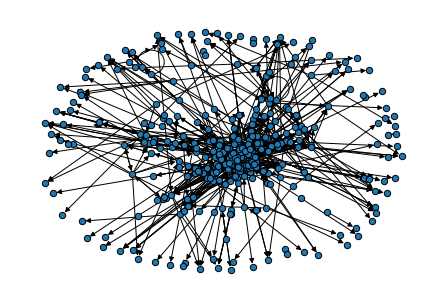

In [41]:
nx.draw(DG, node_size=40, edgecolors="black")